# importacion librerias

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import sympy as sp

# creación modelo

In [7]:
class DQNNetwork(nn.Module):
    """Red neuronal para el agente DQN."""

    def __init__(self, input_dim, output_dim, initial_layer=128, medium_layer=128):
        print("initial_layer: ",initial_layer)
        print("medium_layer: ",medium_layer)
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, initial_layer)
        self.fc2 = nn.Linear(initial_layer, medium_layer)
        self.fc3 = nn.Linear(medium_layer, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN entrenamiennto

In [8]:
class DQNAgent:
    def __init__(
        self,
        env_name="Acrobot-v1",
        episodes=1000,
        gamma=0.99,
        lr=0.001,
        initial_layer=128,
        medium_layer=128,
    ):
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.episodes = episodes
        self.gamma = gamma
        self.lr = lr
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.memory = []
        self.batch_size = 64
        self.replay_buffer_capacity = 10000
        self.initial_layer = initial_layer
        self.medium_layer = medium_layer

        # Para las gráficas
        self.rewards_per_episode = []
        self.best_reward = -np.inf
        self.losses = []  # Para las pérdidas
        self.epsilon_values = []  # Para la decadencia de epsilon
        self.best_rewards_per_episode = []  # Para las mejores recompensas

        # Dimensiones
        input_dim = self.env.observation_space.shape[0]
        output_dim = self.env.action_space.n

        # Inicializar la red y optimizador
        self.network = DQNNetwork(
            input_dim, output_dim, self.initial_layer, self.medium_layer
        )
        self.target_network = DQNNetwork(
            input_dim, output_dim, self.initial_layer, self.medium_layer
        )
        self.target_network.load_state_dict(self.network.state_dict())
        self.target_network.eval()

        # Asegúrate de que 'self.network' esté correctamente definido
        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()


    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar experiencias en la memoria de replay."""
        if len(self.memory) > self.replay_buffer_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria."""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción utilizando la política epsilon-greedy."""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.network(state)).item()

    def update_network(self):
        """Actualizar la red neuronal usando experiencias almacenadas."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Registrar la pérdida
        self.losses.append(loss.item())

    def train(self):
        for episode in tqdm( range(1, self.episodes + 1)):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, done)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.best_rewards_per_episode.append(self.best_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            self.epsilon_values.append(self.epsilon)

            # Actualizar la red objetivo periódicamente
            if episode % 20 == 0:
                self.target_network.load_state_dict(self.network.state_dict())

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()

            # Imprimir métricas cada 100 episodios
            # if episode % 100 == 0:
            #     mean_reward = np.mean(self.rewards_per_episode[-100:])
            #     print(
            #         f"Episode: {episode}, Epsilon: {self.epsilon:.2f}, "
            #         f"Best Reward: {self.best_reward:.1f}, Mean Reward: {mean_reward:.1f}"
            #     )

        self.plot_rewards()

    def save_model(self):
        """Guardar el modelo entrenado."""
        torch.save(self.network.state_dict(), "acrobot_dqn_model.pth")

    def load_model(self):
        """Cargar el modelo entrenado."""
        self.network.load_state_dict(torch.load("acrobot_dqn_model.pth"))
        self.network.eval()

    def plot_rewards(self):
        """Graficar las recompensas acumuladas y métricas del entrenamiento."""
        plt.figure(figsize=(14, 10))

        # Graficar recompensas por episodio
        plt.subplot(2, 2, 1)
        plt.plot(self.rewards_per_episode, label="Rewards per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("DQN Training Performance on Acrobot")
        plt.legend()

        # Graficar la pérdida
        plt.subplot(2, 2, 2)
        plt.plot(self.losses, label="Loss per Update", color="red")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss During Training")
        plt.legend()

        # Graficar la Epsilon Decay
        plt.subplot(2, 2, 3)
        plt.plot(self.epsilon_values, label="Epsilon Decay", color="green")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.title("Epsilon Decay During Training")
        plt.legend()

        # Graficar la mejor recompensa suavizada
        plt.subplot(2, 2, 4)
        # Promedio móvil para suavizar la curva de mejores recompensas
        window_size = 50  # Tamaño de la ventana para el promedio móvil
        best_rewards_smooth = np.convolve(
            self.best_rewards_per_episode,
            np.ones(window_size) / window_size,
            mode="valid",
        )

        plt.plot(best_rewards_smooth, label="Smoothed Best Reward", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Smoothed Best Reward")
        plt.title("Smoothed Best Reward Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

# llamados

initial_layer:  64
medium_layer:  64
initial_layer:  64
medium_layer:  64


100%|██████████| 500/500 [21:05<00:00,  2.53s/it] 


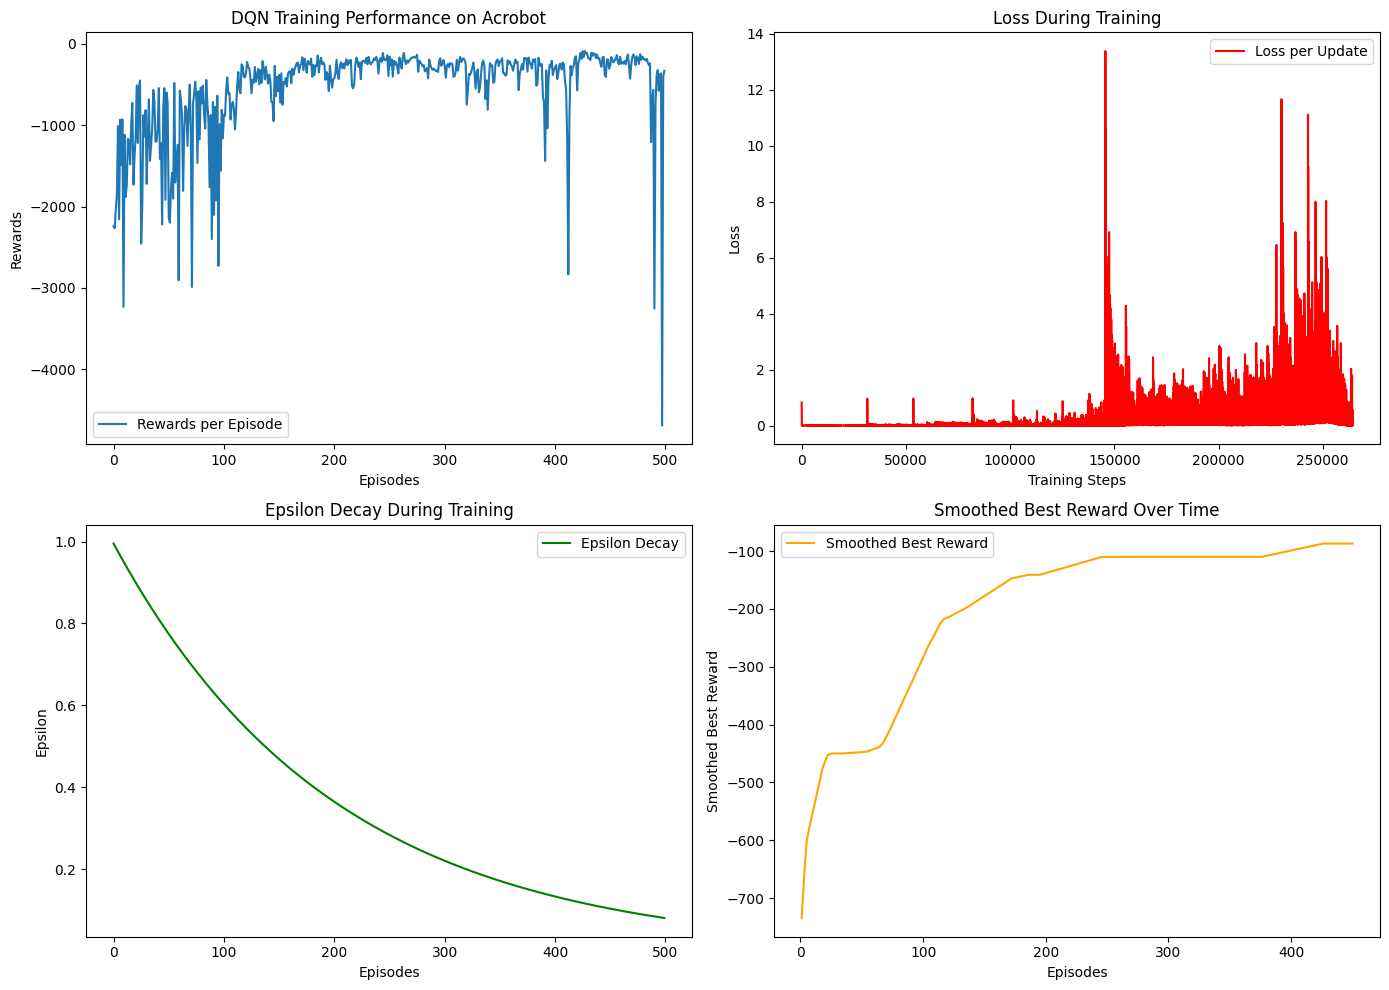

In [9]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=500,initial_layer=64, medium_layer=64)
    agent.train()

initial_layer:  64
medium_layer:  128
initial_layer:  64
medium_layer:  128


100%|██████████| 500/500 [19:16<00:00,  2.31s/it]


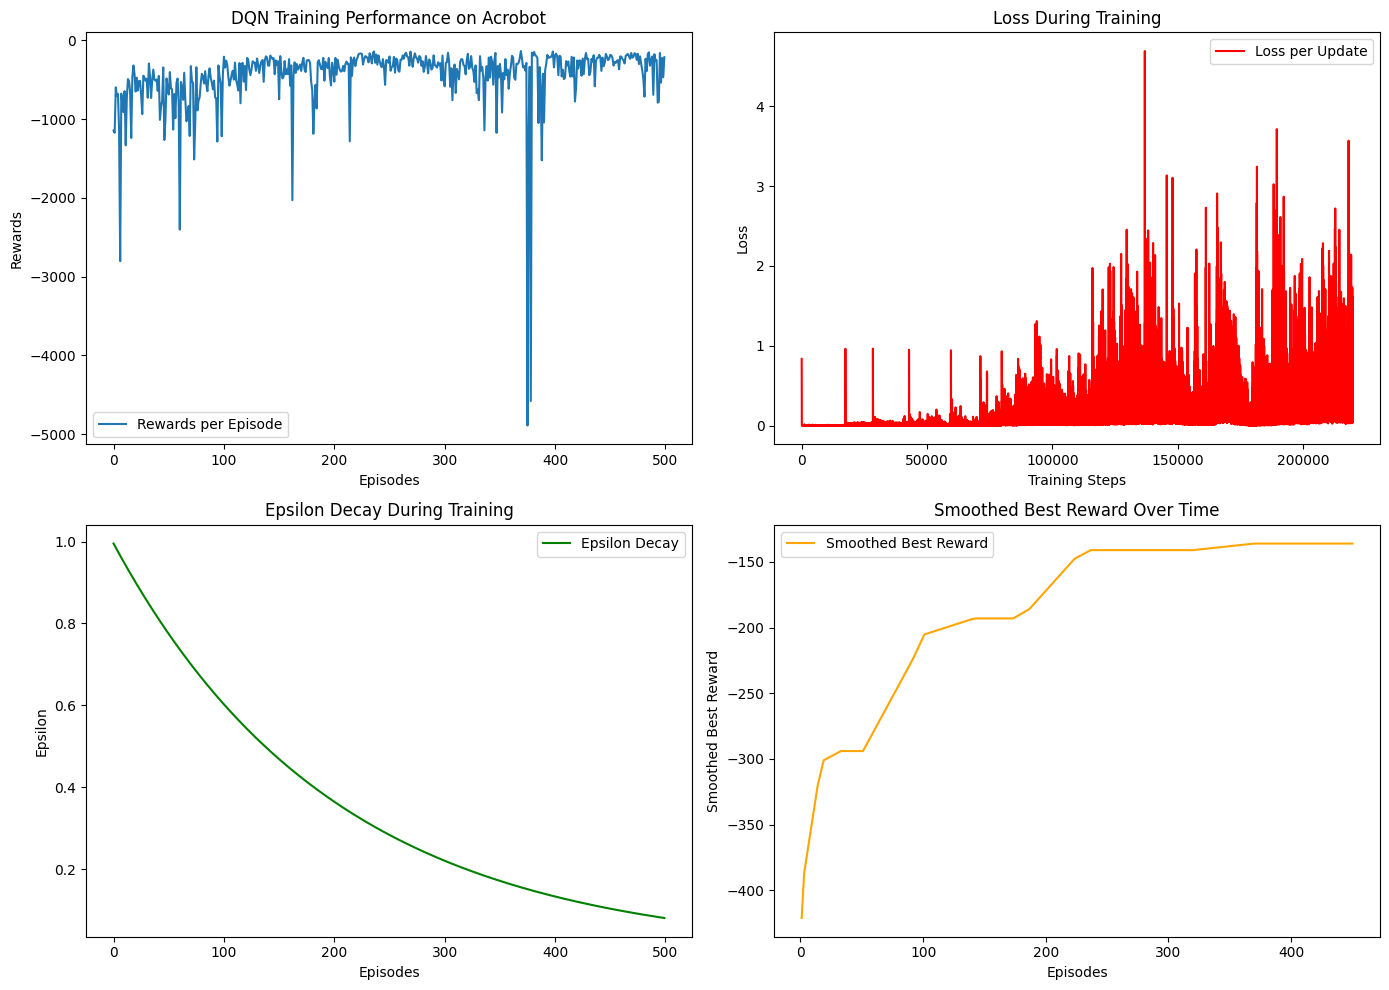

In [10]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=500,initial_layer=64, medium_layer=128)
    agent.train()

# tensor

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class DQNNetworkTensor(keras.Model):
    def __init__(self, input_dim, output_dim):
        super(DQNNetworkTensor, self).__init__()
        self.fc1 = layers.Dense(128, activation="relu", input_shape=(input_dim,))
        self.fc2 = layers.Dense(128, activation="relu")
        self.fc3 = layers.Dense(output_dim)

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return self.fc3(x)


class DQNAgentTensor:
    def __init__(self, env_name="Acrobot-v1", episodes=1000, gamma=0.99, lr=0.001):
        self.env = gym.make(env_name)
        self.episodes = episodes
        self.gamma = gamma  # Factor de descuento
        self.lr = lr  # Tasa de aprendizaje
        self.epsilon = 0.99  # Tasa de exploración inicial
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.memory = []  # Memoria de replay
        self.batch_size = 64
        self.replay_buffer_capacity = 10000

        # Métricas para las gráficas
        self.rewards_per_episode = []
        self.losses = []  # Para almacenar las pérdidas
        self.epsilon_values = []  # Para almacenar los valores de epsilon
        self.best_reward = -np.inf
        self.best_rewards_per_episode = []  # Para las mejores recompensas

        # Dimensiones de entrada y salida
        self.input_dim = self.env.observation_space.shape[0]
        self.output_dim = self.env.action_space.n

        # Inicializar la red y el optimizador
        self.network = DQNNetworkTensor(self.input_dim, self.output_dim)
        self.target_network = DQNNetworkTensor(self.input_dim, self.output_dim)
        self.update_target_network()
        self.optimizer = keras.optimizers.Adam(learning_rate=self.lr)

    def update_target_network(self):
        """Actualiza los pesos de la red objetivo."""
        self.target_network.set_weights(self.network.get_weights())

    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar experiencias en la memoria de replay."""
        if len(self.memory) > self.replay_buffer_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria."""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción utilizando la política epsilon-greedy."""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = np.array(state).reshape(-1, self.input_dim)
        q_values = self.network(state, training=False)
        return np.argmax(q_values[0])

    def update_network(self):
        """Actualizar la red neuronal usando experiencias almacenadas."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones).astype(float)

        # Predecir Q(s,a) y Q(s',a') usando la red actual y la red objetivo
        q_values = self.network(states, training=False)  # Predicción con la red actual
        next_q_values = self.target_network(
            next_states, training=False
        )  # Predicción con la red objetivo

        # Crear un tensor con los targets
        updated_q_values = (
            q_values.numpy().copy()
        )  # Convertir q_values a un array de NumPy para modificarlo

        # Actualizar los Q-values para las acciones tomadas
        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(
                    next_q_values[i]
                )  # Valor de target con descuento
            updated_q_values[i][actions[i]] = (
                target  # Actualizar el Q-value en el índice correspondiente
            )

        # Convertir de nuevo a un tensor de TensorFlow para el entrenamiento
        updated_q_values_tensor = tf.convert_to_tensor(
            updated_q_values, dtype=tf.float32
        )

        # Entrenar la red con los estados y Q-values actualizados
        with tf.GradientTape() as tape:
            q_values_pred = self.network(
                states, training=True
            )  # Predicción de la red para entrenamiento
            loss = tf.reduce_mean(
                tf.square(updated_q_values_tensor - q_values_pred)
            )  # Cálculo de la pérdida

        grads = tape.gradient(loss, self.network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_variables))

        # Almacenar la pérdida
        self.losses.append(loss.numpy())

    def train(self):
        for episode in range(1, self.episodes + 1):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, done)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.best_rewards_per_episode.append(self.best_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            self.epsilon_values.append(self.epsilon)

            # Actualizar la red objetivo periódicamente
            if episode % 2 == 0:
                self.update_target_network()

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()

            # Mostrar estadísticas cada 100 episodios
            mean_reward = np.mean(self.rewards_per_episode[-100:])
            print(
                f"Episodio: {episode}, Epsilon: {self.epsilon:.2f}, "
                f"Mejor Recompensa: {self.best_reward:.1f}, Recompensa Promedio: {mean_reward:.1f}"
            )

        self.plot_metrics()

    def save_model(self):
        """Guardar el modelo entrenado."""
        self.network.save("acrobot_dqn_model.keras")

    def load_model(self):
        """Cargar el modelo entrenado."""
        self.network = keras.models.load_model("acrobot_dqn_model.keras")
        self.update_target_network()

    def plot_metrics(self):
        """Graficar las métricas de rendimiento durante el entrenamiento."""
        plt.figure(figsize=(14, 10))

        # Graficar recompensas por episodio
        plt.subplot(2, 2, 1)
        plt.plot(self.rewards_per_episode, label="Recompensa por Episodio")
        plt.xlabel("Episodios")
        plt.ylabel("Recompensa")
        plt.title("Recompensas por Episodio")
        plt.legend()

        # Graficar la pérdida
        plt.subplot(2, 2, 2)
        plt.plot(self.losses, label="Pérdida por Actualización", color="red")
        plt.xlabel("Pasos de Entrenamiento")
        plt.ylabel("Pérdida")
        plt.title("Pérdida Durante el Entrenamiento")
        plt.legend()

        # Graficar la Epsilon Decay
        plt.subplot(2, 2, 3)
        plt.plot(self.epsilon_values, label="Decadencia de Epsilon", color="green")
        plt.xlabel("Episodios")
        plt.ylabel("Epsilon")
        plt.title("Decadencia de Epsilon Durante el Entrenamiento")
        plt.legend()

        # Graficar la mejor recompensa suavizada
        plt.subplot(2, 2, 4)
        # window_size = 50  # Tamaño de la ventana para el promedio móvil
        # best_rewards_smooth = np.convolve(
        #     self.best_rewards_per_episode,
        #     np.ones(window_size) / window_size,
        #     mode="valid",
        # )

        plt.plot(
            self.best_rewards_per_episode,
            label="Recompensa Mejorada Suavizada",
            color="orange",
        )
        plt.xlabel("Episodios")
        plt.ylabel("Recompensa Mejorada Suavizada")
        plt.title("Mejor Recompensa Suavizada")
        plt.legend()

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    agent = DQNAgentTensor(episodes=10)
    agent.train()
